## 获取/判断股票涨跌停

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
pd.set_option('display.max_rows', 50)

/mnt/datadisk2/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
open2021 = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/open_2021.h5')
open2021 = open2021.set_index(['Date', 'EndTime'])
open2021

InstrumentID      SH600000  SH600004  SH600006  SH600007  SH600008  SH600009  \
Date     EndTime                                                               
20210104 09:31        9.64     14.10      8.95     12.45      2.86     75.70   
         09:32        9.64     14.01      8.82     12.35      2.86     76.46   
         09:33        9.60     13.97      8.84     12.36      2.84     76.17   
         09:34        9.60     14.00      8.83     12.37      2.85     76.10   
         09:35        9.58     13.90      8.83     12.33      2.85     75.74   
...                    ...       ...       ...       ...       ...       ...   
20211231 14:56        8.55     12.04      6.81     14.41      3.41     46.68   
         14:57        8.54     12.03      6.81     14.41      3.40     46.68   
         14:58        8.55     12.03      6.81     14.39      3.41     46.70   
         14:59        8.55     12.03      6.81     14.39      3.41     46.70   
         15:00        8.55     12.03      6.81     14.39      3.41     46.70   

InstrumentID      SH600010  SH600011  SH600012  SH600015  ...  SZ301190  \
Date     EndTime                                          ...             
20210104 09:31        1.17      4.50      6.14      6.22  ...       NaN   
         09:32        1.18      4.49      6.12      6.22  ...       NaN   
         09:33        1.17      4.47      6.16      6.20  ...       NaN   
         09:34        1.17      4.47      6.17      6.21  ...       NaN   
         09:35        1.17      4.46      6.16      6.21  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
20211231 14:56        2.78      9.64      7.07      5.59  ...     30.31   
         14:57        2.79      9.65      7.07      5.59  ...     30.28   
         14:58        2.79      9.65      7.06      5.60  ...     30.20   
         14:59        2.79      9.65      7.06      5.60  ...     30.20   
         15:00        2.79      9.65      7.06      5.60  ...     30.20   

InstrumentID      SH688210  SH688206  SH688265  SZ301166  SZ301189  SH688227  \
Date     EndTime                                                               
20210104 09:31         NaN       NaN       NaN       NaN       NaN       NaN   
         09:32         NaN       NaN       NaN       NaN       NaN       NaN   
         09:33         NaN       NaN       NaN       NaN       NaN       NaN   
         09:34         NaN       NaN       NaN       NaN       NaN       NaN   
         09:35         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
20211231 14:56       41.48     36.95     69.92    104.04     60.49     32.14   
         14:57       41.51     36.93     70.00    103.70     60.32     32.12   
         14:58       41.48     36.73     70.05    103.20     60.05     32.09   
         14:59       41.48     36.73     70.05    103.30     60.02     32.09   
         15:00       41.48     36.73     70.05    103.30     60.02     32.09   

InstrumentID      SH688236  SZ301127  SH603176  
Date     EndTime                                
20210104 09:31         NaN       NaN       NaN  
         09:32         NaN       NaN       NaN  
         09:33         NaN       NaN       NaN  
         09:34         NaN       NaN       NaN  
         09:35         NaN       NaN       NaN  
...                    ...       ...       ...  
20211231 14:56       27.39     20.23      2.45  
         14:57       27.40     20.30      2.45  
         14:58       27.39     20.25      2.45  
         14:59       27.39     20.19      2.45  
         15:00       27.39     20.19      2.45  

[58320 rows x 4622 columns]

In [132]:
def is_stop_trade(price:pd.DataFrame, std_level=1e-6, back_period=-15, updown_level=0.08):
    '''
    判断某只股票是否涨停跌停, 1为可以正常交易, 0为涨停跌停 
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''

    def _is_stop_trade(price_daily:pd.DataFrame):
        return pd.Series(np.where(
            (price_daily.iloc[back_period:].std() < std_level) & (np.abs(price_daily.iloc[-1] / price_daily.iloc[0]) - 1 > updown_level),
            0, 1), index=price_daily.columns)
    
    return pd.DataFrame(price.groupby(level='Date').progress_apply(_is_stop_trade), columns=price.columns)

def get_stop_stock(price:pd.DataFrame, std_level=1e-6, back_period=-15, updown_level=0.08):
    '''
    返回在某个日期涨停跌停的股票
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''
    
    def _get_stop_stock(price_daily:pd.DataFrame):
        jg = (price_daily.iloc[back_period:].std() < std_level) & (np.abs(price_daily.iloc[-1] / price_daily.iloc[0]) - 1 > updown_level)
        return jg[jg == True].index.to_list()
    
    return price.groupby(level='Date').progress_apply(_get_stop_stock)

In [3]:
def is_stop_trade(price:pd.DataFrame, std_level=1e-6, back_period=-15, updown_level=0.1):
    '''
    判断某只股票是否涨停跌停, 1为可以正常交易, 0为涨停跌停 
    price:分钟级价格数据, multi-index对象 
    std_level:认为停止交易的数据标准差阈值 
    back_period:回溯时间期, 单位min
    updown_level:认为涨跌停幅度阈值
    '''

    def _is_stop_trade(price_daily:pd.DataFrame):
        return pd.Series(np.where(
            (price_daily.max() / price_daily.iloc[0] - 1 > updown_level) | (1 - price_daily.min() / price_daily.iloc[0] > updown_level),
            0, 1), index=price_daily.columns)
    
    return pd.DataFrame(price.groupby(level='Date').progress_apply(_is_stop_trade), columns=price.columns)

In [4]:
stop_stock = is_stop_trade(open2021)
stop_stock

InstrumentID,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210105,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210106,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210107,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20210108,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20211228,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,0,1,1,1,1
20211229,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,1


In [5]:
stop_stock = stop_stock.replace(0, np.nan)
stop_stock

InstrumentID,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
20210105,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
20210106,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
20210107,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
20210108,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,1.0,1,1.0,1.0,1,1,1.0,1.0
20211228,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,1.0,1,NaN,1,NaN,NaN,1,1,1.0,1.0
20211229,1,1,1.0,1.0,1,1,1.0,1.0,1,1,...,NaN,1,1.0,1,NaN,1.0,1,1,1.0,1.0


In [6]:
stop_stock.isna().sum(axis=1)

Date
20210104     80
20210105    104
20210106     74
20210107     86
20210108     82
           ... 
20211227     90
20211228     83
20211229     73
20211230     80
20211231     68
Length: 243, dtype: int64

In [9]:
s_s_0104 = stop_stock.isna().iloc[0][stop_stock.isna().iloc[0]].index.tolist()
s_s_0104

['SH600121',
 'SH600257',
 'SH600292',
 'SH600293',
 'SH600438',
 'SH600569',
 'SH600619',
 'SH600956',
 'SH600971',
 'SH601012',
 'SH603103',
 'SH603126',
 'SH603218',
 'SH603319',
 'SH603617',
 'SH603809',
 'SH603995',
 'SH688006',
 'SH688011',
 'SH688023',
 'SH688058',
 'SH688063',
 'SH688116',
 'SH688157',
 'SH688390',
 'SH688510',
 'SH688526',
 'SH688536',
 'SH688568',
 'SH688686',
 'SZ000032',
 'SZ000150',
 'SZ000708',
 'SZ000738',
 'SZ000791',
 'SZ000899',
 'SZ001896',
 'SZ002006',
 'SZ002202',
 'SZ002368',
 'SZ002453',
 'SZ002545',
 'SZ002594',
 'SZ002597',
 'SZ002612',
 'SZ002651',
 'SZ002796',
 'SZ002852',
 'SZ002975',
 'SZ003031',
 'SZ300008',
 'SZ300014',
 'SZ300035',
 'SZ300082',
 'SZ300115',
 'SZ300123',
 'SZ300261',
 'SZ300274',
 'SZ300337',
 'SZ300393',
 'SZ300447',
 'SZ300454',
 'SZ300457',
 'SZ300476',
 'SZ300478',
 'SZ300549',
 'SZ300616',
 'SZ300617',
 'SZ300618',
 'SZ300700',
 'SZ300726',
 'SZ300750',
 'SZ300752',
 'SZ300761',
 'SZ300762',
 'SZ300863',
 'SZ300894',

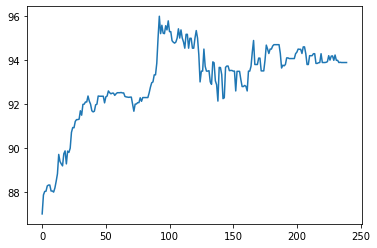

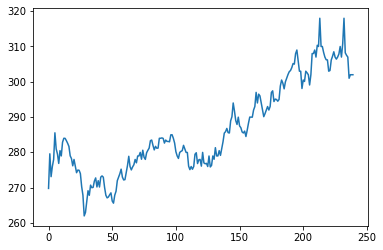

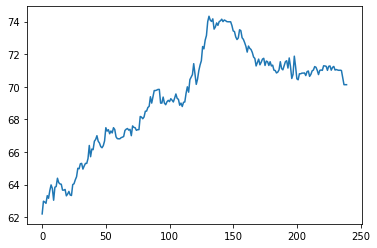

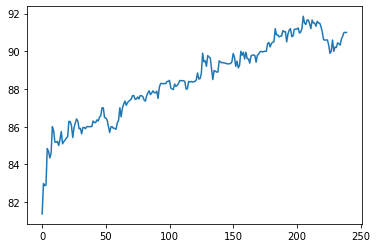

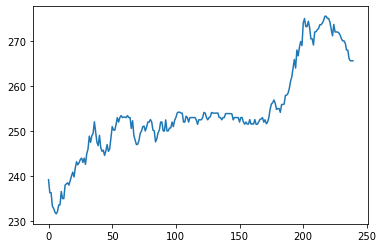

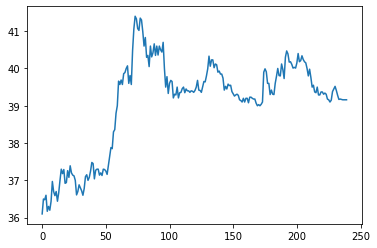

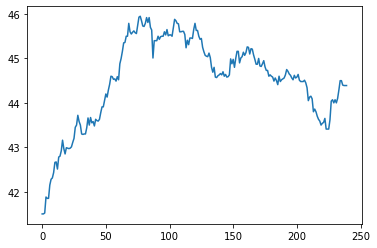

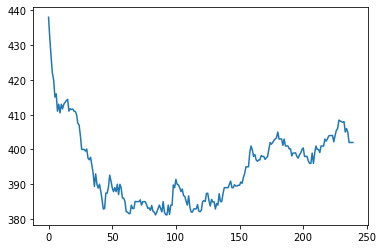

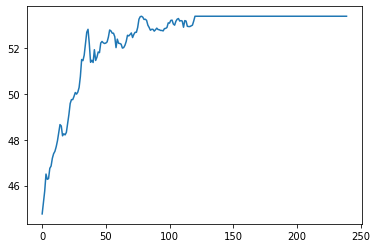

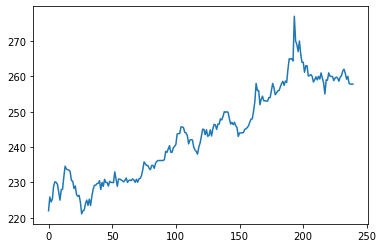

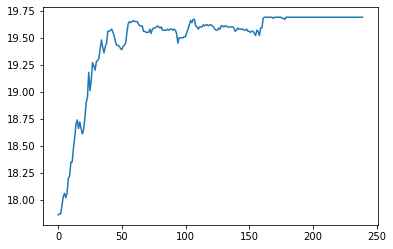

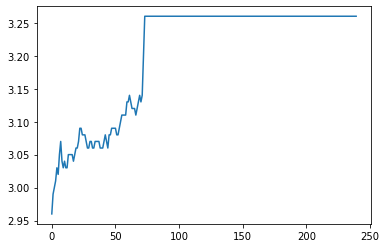

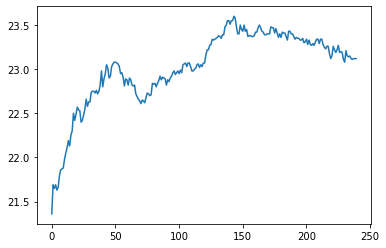

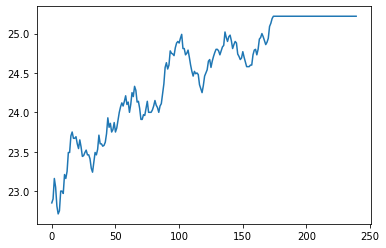

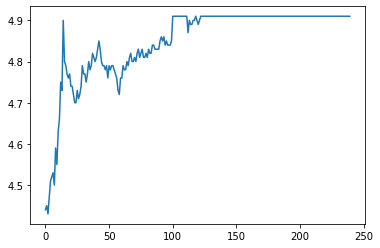

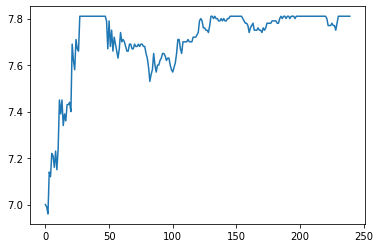

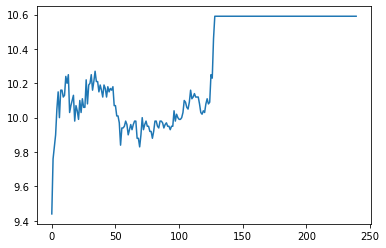

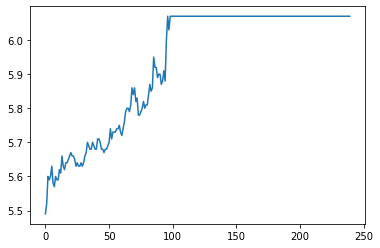

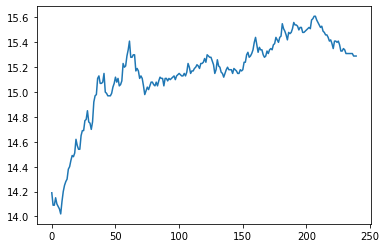

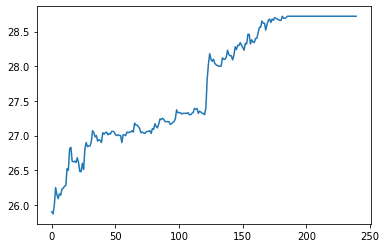

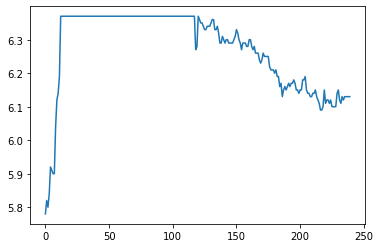

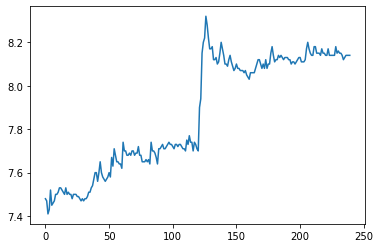

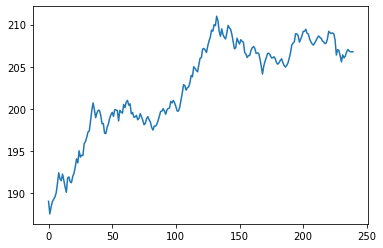

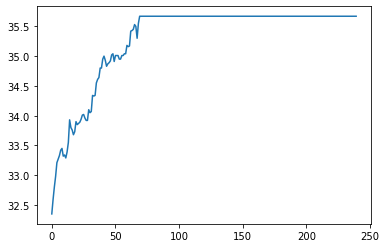

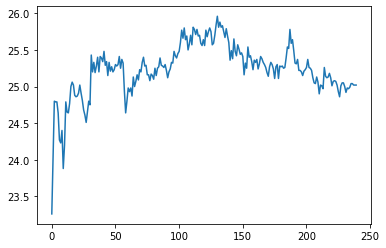

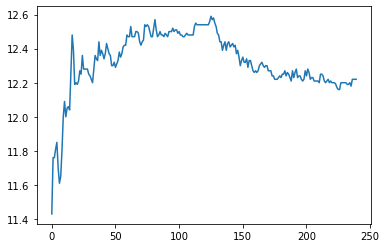

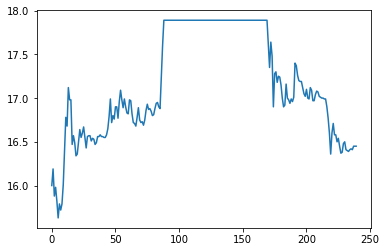

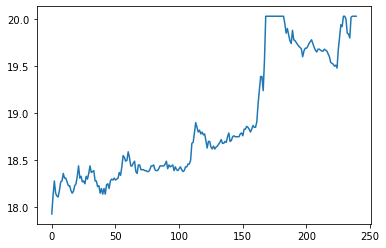

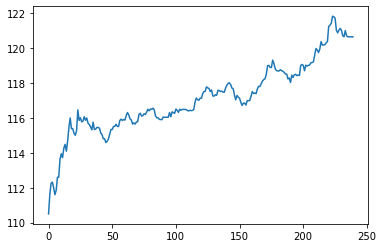

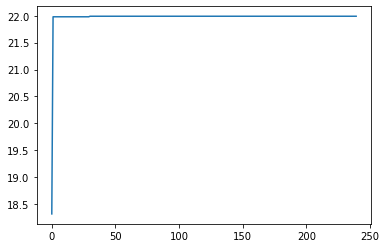

In [12]:
import matplotlib.pyplot as plt
for i in range(20, 50):
    s = open2021[s_s_0104[i]]
    plt.plot(s[:240].values)
    plt.show()

In [13]:
factor = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/min_corr/extre_return_absmax_min.csv')
factor = factor.set_index('Date')
factor

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,0.006218,0.007174,0.014525,0.008032,0.007018,0.010040,0.008621,0.006652,0.006557,0.004847,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20210105,0.003145,0.005814,0.014054,0.004016,0.007067,0.010452,0.008621,0.008889,0.009852,0.004839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20210106,0.005192,0.007246,0.012600,0.009547,0.007067,0.005640,0.008621,0.006818,0.011272,0.004792,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20210107,0.007085,0.006742,0.020606,0.015561,0.007092,0.005600,0.017241,0.006772,0.007937,0.004785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20210108,0.004098,0.008574,0.023529,0.004894,0.014085,0.005370,0.008621,0.006834,0.006645,0.004800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.002342,0.007951,0.007310,0.007852,0.005882,0.006343,0.010909,0.013752,0.004317,0.003584,...,0.057204,0.030266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20211228,0.002339,0.005983,0.002915,0.004954,0.005988,0.005712,0.010870,0.020471,0.007194,0.001792,...,0.013514,0.035943,0.145112,0.037542,0.097921,0.095554,0.000000,0.000000,0.000000,0.00000
20211229,0.002336,0.015504,0.005789,0.003534,0.008955,0.006128,0.010676,0.021277,0.004292,0.001792,...,0.017576,0.006757,0.015420,0.030479,0.035088,0.023527,0.000000,0.000000,0.000000,0.00000


In [16]:
factor.index = stop_stock.index
factor.index

Index(['20210104', '20210105', '20210106', '20210107', '20210108', '20210111',
       '20210112', '20210113', '20210114', '20210115',
       ...
       '20211220', '20211221', '20211222', '20211223', '20211224', '20211227',
       '20211228', '20211229', '20211230', '20211231'],
      dtype='object', name='Date', length=243)

In [17]:
new_factor = factor * stop_stock
new_factor

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301190,SH688210,SH688206,SH688265,SZ301166,SZ301189,SH688227,SH688236,SZ301127,SH603176
Date,,,,,,,,,,,,,,,,,,,,,
20210104,0.006218,0.007174,0.014525,0.008032,0.007018,0.010040,0.008621,0.006652,0.006557,0.004847,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20210105,0.003145,0.005814,0.014054,0.004016,0.007067,0.010452,0.008621,0.008889,0.009852,0.004839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20210106,0.005192,0.007246,0.012600,0.009547,0.007067,0.005640,0.008621,0.006818,0.011272,0.004792,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20210107,0.007085,0.006742,0.020606,0.015561,0.007092,0.005600,0.017241,0.006772,0.007937,0.004785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20210108,0.004098,0.008574,0.023529,0.004894,0.014085,0.005370,0.008621,0.006834,0.006645,0.004800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.002342,0.007951,0.007310,0.007852,0.005882,0.006343,0.010909,0.013752,0.004317,0.003584,...,0.057204,0.030266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20211228,0.002339,0.005983,0.002915,0.004954,0.005988,0.005712,0.010870,0.020471,0.007194,0.001792,...,0.013514,0.035943,NaN,0.037542,NaN,NaN,0.000000,0.000000,0.000000,0.0
20211229,0.002336,0.015504,0.005789,0.003534,0.008955,0.006128,0.010676,0.021277,0.004292,0.001792,...,NaN,0.006757,0.015420,0.030479,NaN,0.023527,0.000000,0.000000,0.000000,0.0


In [18]:
new_factor.isna().sum(axis=1)

Date
20210104     80
20210105    104
20210106     74
20210107     86
20210108     82
           ... 
20211227     90
20211228     83
20211229     73
20211230     80
20211231     68
Length: 243, dtype: int64

In [19]:
new_factor.to_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/min_corr/extre_return_absmax_dropstop_min.csv')